In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence

###Generate some fake data for binary classification

In [2]:
X, y = make_hastie_10_2(random_state=1234)
y = (y == 1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, random_state=4321)

###Fit a gradient boosting classifier

In [3]:
gbc = GradientBoostingClassifier(n_estimators=5000, 
                                 learning_rate=0.02, 
                                 max_depth=2, 
                                 max_features=3,
                                 subsample=0.75)
gbc.fit(X_train, y_train)
print metrics.accuracy_score(y_test, gbc.predict(X_test))

0.960833333333


###Evaluate OOB and test performance

In [4]:
oob_loss = -np.cumsum(gbc.oob_improvement_)
test_loss = [gbc.loss_(y_test, y_pred) 
             for _, y_pred in enumerate(gbc.staged_decision_function(X_test))]
test_loss -= test_loss[0]  # adjust by first value

###Plot OOB and test performance over trees

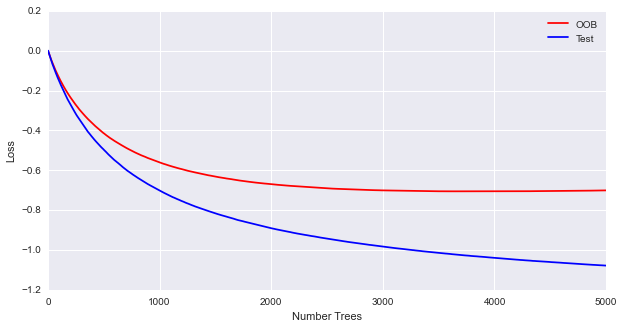

In [5]:
trees = np.arange(len(gbc.estimators_)) + 1
plt.figure(figsize=(10, 5))
plt.plot(trees, oob_loss, linestyle='-', color='r', label='OOB')
plt.plot(trees, test_loss, linestyle='-', color='b', label='Test')
plt.xlabel('Number Trees'); plt.ylabel('Loss'); 
plt.legend(loc='best'); 

###Feature importances

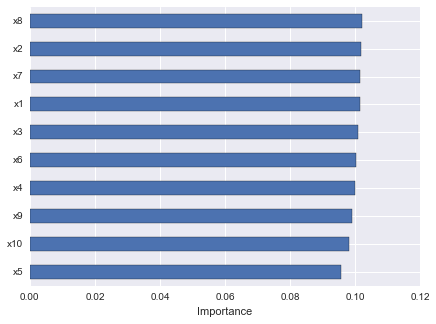

In [6]:
idx = ['x' + str(i + 1) for i in xrange(10)]
var_imp = pd.Series(gbc.feature_importances_, index=idx)
var_imp.sort()
plt.figure(figsize=(7, 5))
var_imp.plot(kind='barh')
plt.xlabel('Importance');

###Partial Dependence Plots

Let's plot partial dependence over values of $x_1$, holding all features at their observed values. 

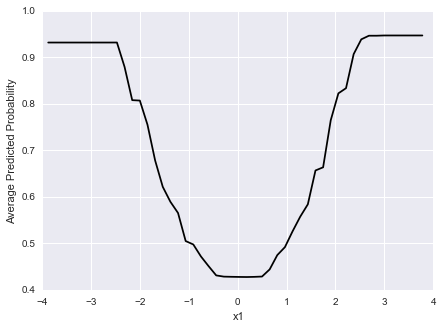

In [7]:
def evaluate_partial_dependence(model, features, var):
    df = features.copy() 
    rng = np.linspace(df[var].min(), df[var].max())
    preds = []
    for val in rng: 
        df[var] = val
        preds.append(model.predict_proba(df)[:,1].mean())
    return rng, preds

features = pd.DataFrame(X_train, columns=idx)
x1, preds = evaluate_partial_dependence(gbc, features, 'x1')
plt.figure(figsize=(7, 5))
plt.plot(x1, preds, 'k')
plt.xlabel('x1'); plt.ylabel('Average Predicted Probability'); 

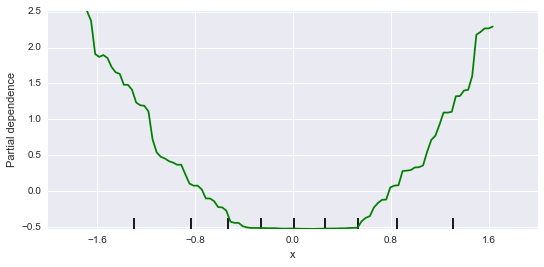

In [8]:
plot_partial_dependence(gbc, X_train, features=[0], feature_names='x1'); 